## Solve ODEs using Neural Networks
*July 9th, 2024*

[Problem Description](https://datascience.stackexchange.com/questions/45015/solving-an-ode-using-neural-networks-via-tensorflow) (Data Science Stack Exchange)

In [1]:
import math
import torch
import numpy as np
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ConstantLR

# Learning Parameters
batch_size = 20                 # Amount of Training observations per batch
ic_coeff = 7                    # Initial condition Coefficient
momentum = 0.9                  # Accelerate optimization during training
num_epochs = 20                 # Number of Epochs for training phase
initial_learn_rate = 0.003      # Learning rate employed at the beginning of training

In [2]:
# Get Device for Training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
# Neural Network Architecture
class ODE_NeuralNetwork(nn.Module):
    def __init__(self, hidden_size, output_size=1, input_size=1) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [4]:
model = ODE_NeuralNetwork(hidden_size=200).to(device)
model

ODE_NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=200, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [5]:
# Create the arrays x and y, where x is a discretization of the domain (a,b) and y is the source term f(x)
N = 10000; N_test = 1000; a = 0; b = 2
X_train = np.arange(a, b, (b - a) / N, dtype=np.float32).reshape((N, 1))
y = np.zeros(N)

# Boundary conditions
A = 1.0 ; B = 0.0

# Training Dataset
Xtrain_tensor = torch.from_numpy(X_train).reshape(len(X_train), 1).to(device)
Xtrain_tensor.requires_grad_(True)

train_dataloader = DataLoader(Xtrain_tensor, batch_size=batch_size, shuffle=True)

# Test Dataset
X_test = np.linspace(0, 1, N_test, dtype=np.float32).reshape((N_test, 1))
Xtest_tensor = torch.from_numpy(X_test).reshape(len(X_test), 1).to(device)

In [6]:
# Loss function and Optimizer definition
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=initial_learn_rate)
scheduler = ConstantLR(optimizer, 0.5)

In [7]:
# Training Loop
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    for batch in train_dataloader:
        # Forward pass
        y = model(batch)

        # Calculate the derivative of the forward pass w.r.t the batch input (x)
        dy = torch.autograd.grad(y,
                                batch,
                                grad_outputs=torch.ones_like(y),
                                retain_graph=True)[0]
        
        # Define differential equation and calculate the loss
        loss_DE = dy + 2 * y * batch

        # Define the initial condition loss
        loss_IC = model(torch.tensor([[0.0]]).to(device)) - 1

        loss = criterion(loss_DE, torch.zeros(batch_size, 1).to(device) + ic_coeff * criterion(loss_IC, torch.zeros(1, 1).to(device)))

        # Backward pass and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Updates the loss per batch
        epoch_loss += loss.item()
    
    if (epoch % 10 == 0):
        print(f"Epoch {epoch} | Loss: {epoch_loss}")

Epoch 10 | Loss: 1.1017248546486371
Epoch 20 | Loss: 0.371911554199869


In [8]:
# Once the model is trained, we perform predictions through the test data
preds = []
with torch.no_grad():
    for input in Xtest_tensor:
        outputs = model(input)
        preds.append(outputs.cpu().detach().numpy()[0])

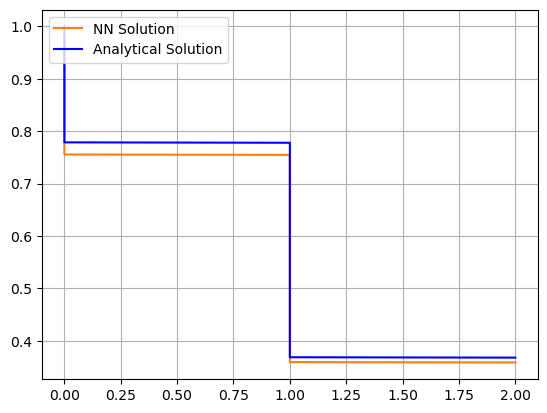

In [10]:
x = np.linspace(a, b, num=N_test, dtype=np.int32)
y_analytical = [np.exp(-math.pow(x/N_test, 2)) for x in range(1, N_test+1)]

plt.plot(x, preds, "tab:orange", label="NN Solution")
plt.plot(x, y_analytical, "b", label="Analytical Solution")
plt.legend(loc="upper left")
plt.grid()
plt.show()